<a href="https://colab.research.google.com/github/parament-integrator/examples/blob/master/Convergence_Plot_Paper_Version%20-%20Kopie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!NVCC_ARGS="-arch=compute_37" pip install git+https://github.com/parament-integrator/parament#subdirectory=src

  Cloning https://github.com/parament-integrator/parament to /tmp/pip-req-build-wfjndmxq
  Running command git clone -q https://github.com/parament-integrator/parament /tmp/pip-req-build-wfjndmxq
  Created wheel for parament: filename=parament-0.1-py3-none-linux_x86_64.whl size=781720 sha256=408cbe6853adb98169175e94a3e7796cffe53a17f89191f07d4b343d8e67ccf7
  Stored in directory: /tmp/pip-ephem-wheel-cache-v_b_3loa/wheels/30/d6/35/c1497ea3f67415126ff9dcde263bc6c57e63b2e80d38e99fc5
Successfully built parament


In [2]:
!pip install qutip

     |████████████████████████████████| 14.6MB 204kB/s 


In [4]:
import numpy as np
import scipy.linalg
from numba import njit, prange
import qutip as qu

import matplotlib.pyplot as plt

In [5]:
import sys
import os
import parament

In [6]:
dtype_base = np.complex128

ox = np.array([[0,1],[1,0]],dtype=dtype_base)
oy = np.array([[0,-1j],[1j,0]],dtype=dtype_base)
oz = np.array([[1,0],[0,-1]],dtype=dtype_base)
oe = np.array([[1,0],[0,1]],dtype=dtype_base)

w0  = 1.0
w1  = 0.1
wrf = 1.0
TSTOP = 6

H0 = w0/2 * oz
H1 = w1/2 * ox
H2 = w1/2 * oy
Hc = np.zeros((2,2,2),dtype=dtype_base)
Hc[:,:,0] = H1
Hc[:,:,1] = H2

In [10]:
def Uexact(t):
    dw = w0 - wrf
    #print(dw)
    gen = np.sqrt(w1**2+dw**2)
    explabM = np.exp(-0.5j*t*wrf)
    explabP = np.exp(0.5j*t*wrf)
    x = 0.5*gen*t
    fact1 = dw/gen
    fact2 = w1/gen
    M1 = explabM*(np.cos(x) + 1j*fact1 * np.sin(x))
    M2 = explabM*(-1j*fact2*np.sin(x))
    M3 = explabP*(-1j*fact2*np.sin(x))
    M4 = explabP*(np.cos(x) - 1j*fact1 * np.sin(x))  
    return np.array([[M1,M2],[M3,M4]])
    

In [24]:
def compare(pts,prec,magnus,quad):
    print(pts)
    GPURunner = parament.Parament(precision=prec)
    GPURunner.set_hamiltonian(H0,Hc,use_magnus=magnus,quadrature_mode=quad)
    t = np.linspace(0,TSTOP,pts)
    dt = t[1]-t[0]
    carr1 = (np.cos(wrf*t))
    carr2 = (np.sin(wrf*t))

    carr = np.array([carr1,carr2])
    carr = np.transpose(carr)
    outGPU = GPURunner.equiprop(dt, carr)
    #u,s,v = np.linalg.svd(outGPU)
    #outGPU = u @ v
    print(outGPU)
    print("------------")
    Qout = qu.Qobj(outGPU).tidyup()
    GPURunner.destroy()
    propagator_exact = Uexact(TSTOP)
    Ndiff = outGPU - propagator_exact
    Qexact = qu.Qobj(propagator_exact).tidyup()
    Qdiff = Qout - Qexact
    norm_diff = np.linalg.norm(Qdiff.data.todense())
    print(norm_diff)
    return norm_diff

In [25]:
steps = np.logspace(1,4.5,dtype=int)
for i in range(len(steps)):
    if steps[i] % 2 == 0:
        steps[i] = steps[i]+1

In [26]:
y1 = qu.serial_map(compare,steps,task_args=('fp32',True,'simpson'))
y2 = qu.serial_map(compare,steps,task_args=('fp32',False,'midpoint'))
y3 = qu.serial_map(compare,steps,task_args=('fp32',False,'simpson'))



11
[[ 0.94499266-0.3086653j   0.03134258-0.10359915j]
 [-0.03134258-0.10359915j  0.9449927 +0.3086653j ]]
------------
2.744998846672902
11
[[ 0.94499266-0.3086653j   0.03134258-0.10359915j]
 [-0.03134258-0.10359915j  0.9449927 +0.3086653j ]]
------------
2.744998846672902
13
[[ 0.96999186-0.21243928j  0.023178  -0.11596423j]
 [-0.02317798-0.11596422j  0.969992  +0.21243933j]]
------------
2.773912665496696
17
[[ 0.9876325 -0.08957229j  0.00965902-0.12831819j]
 [-0.00965901-0.1283182j   0.98763245+0.08957227j]]
------------
2.7999622248170697
19
[[ 0.9901301 -0.04828215j  0.00449245-0.13149887j]
 [-0.00449244-0.1314989j   0.99012995+0.04828236j]]
------------
2.8061299652560825
23
[[ 0.99074453+0.01184677j -0.00346816-0.13518311j]
 [ 0.00346817-0.13518311j  0.9907441 -0.01184686j]]
------------
2.8128453955188095
27
[[ 0.9890814 +0.0534245j  -0.00921845-0.13704374j]
 [ 0.00921845-0.13704371j  0.9890813 -0.05342442j]]
------------
2.815927820753052
31
[[ 0.9867798 +0.08384287j -0.013524

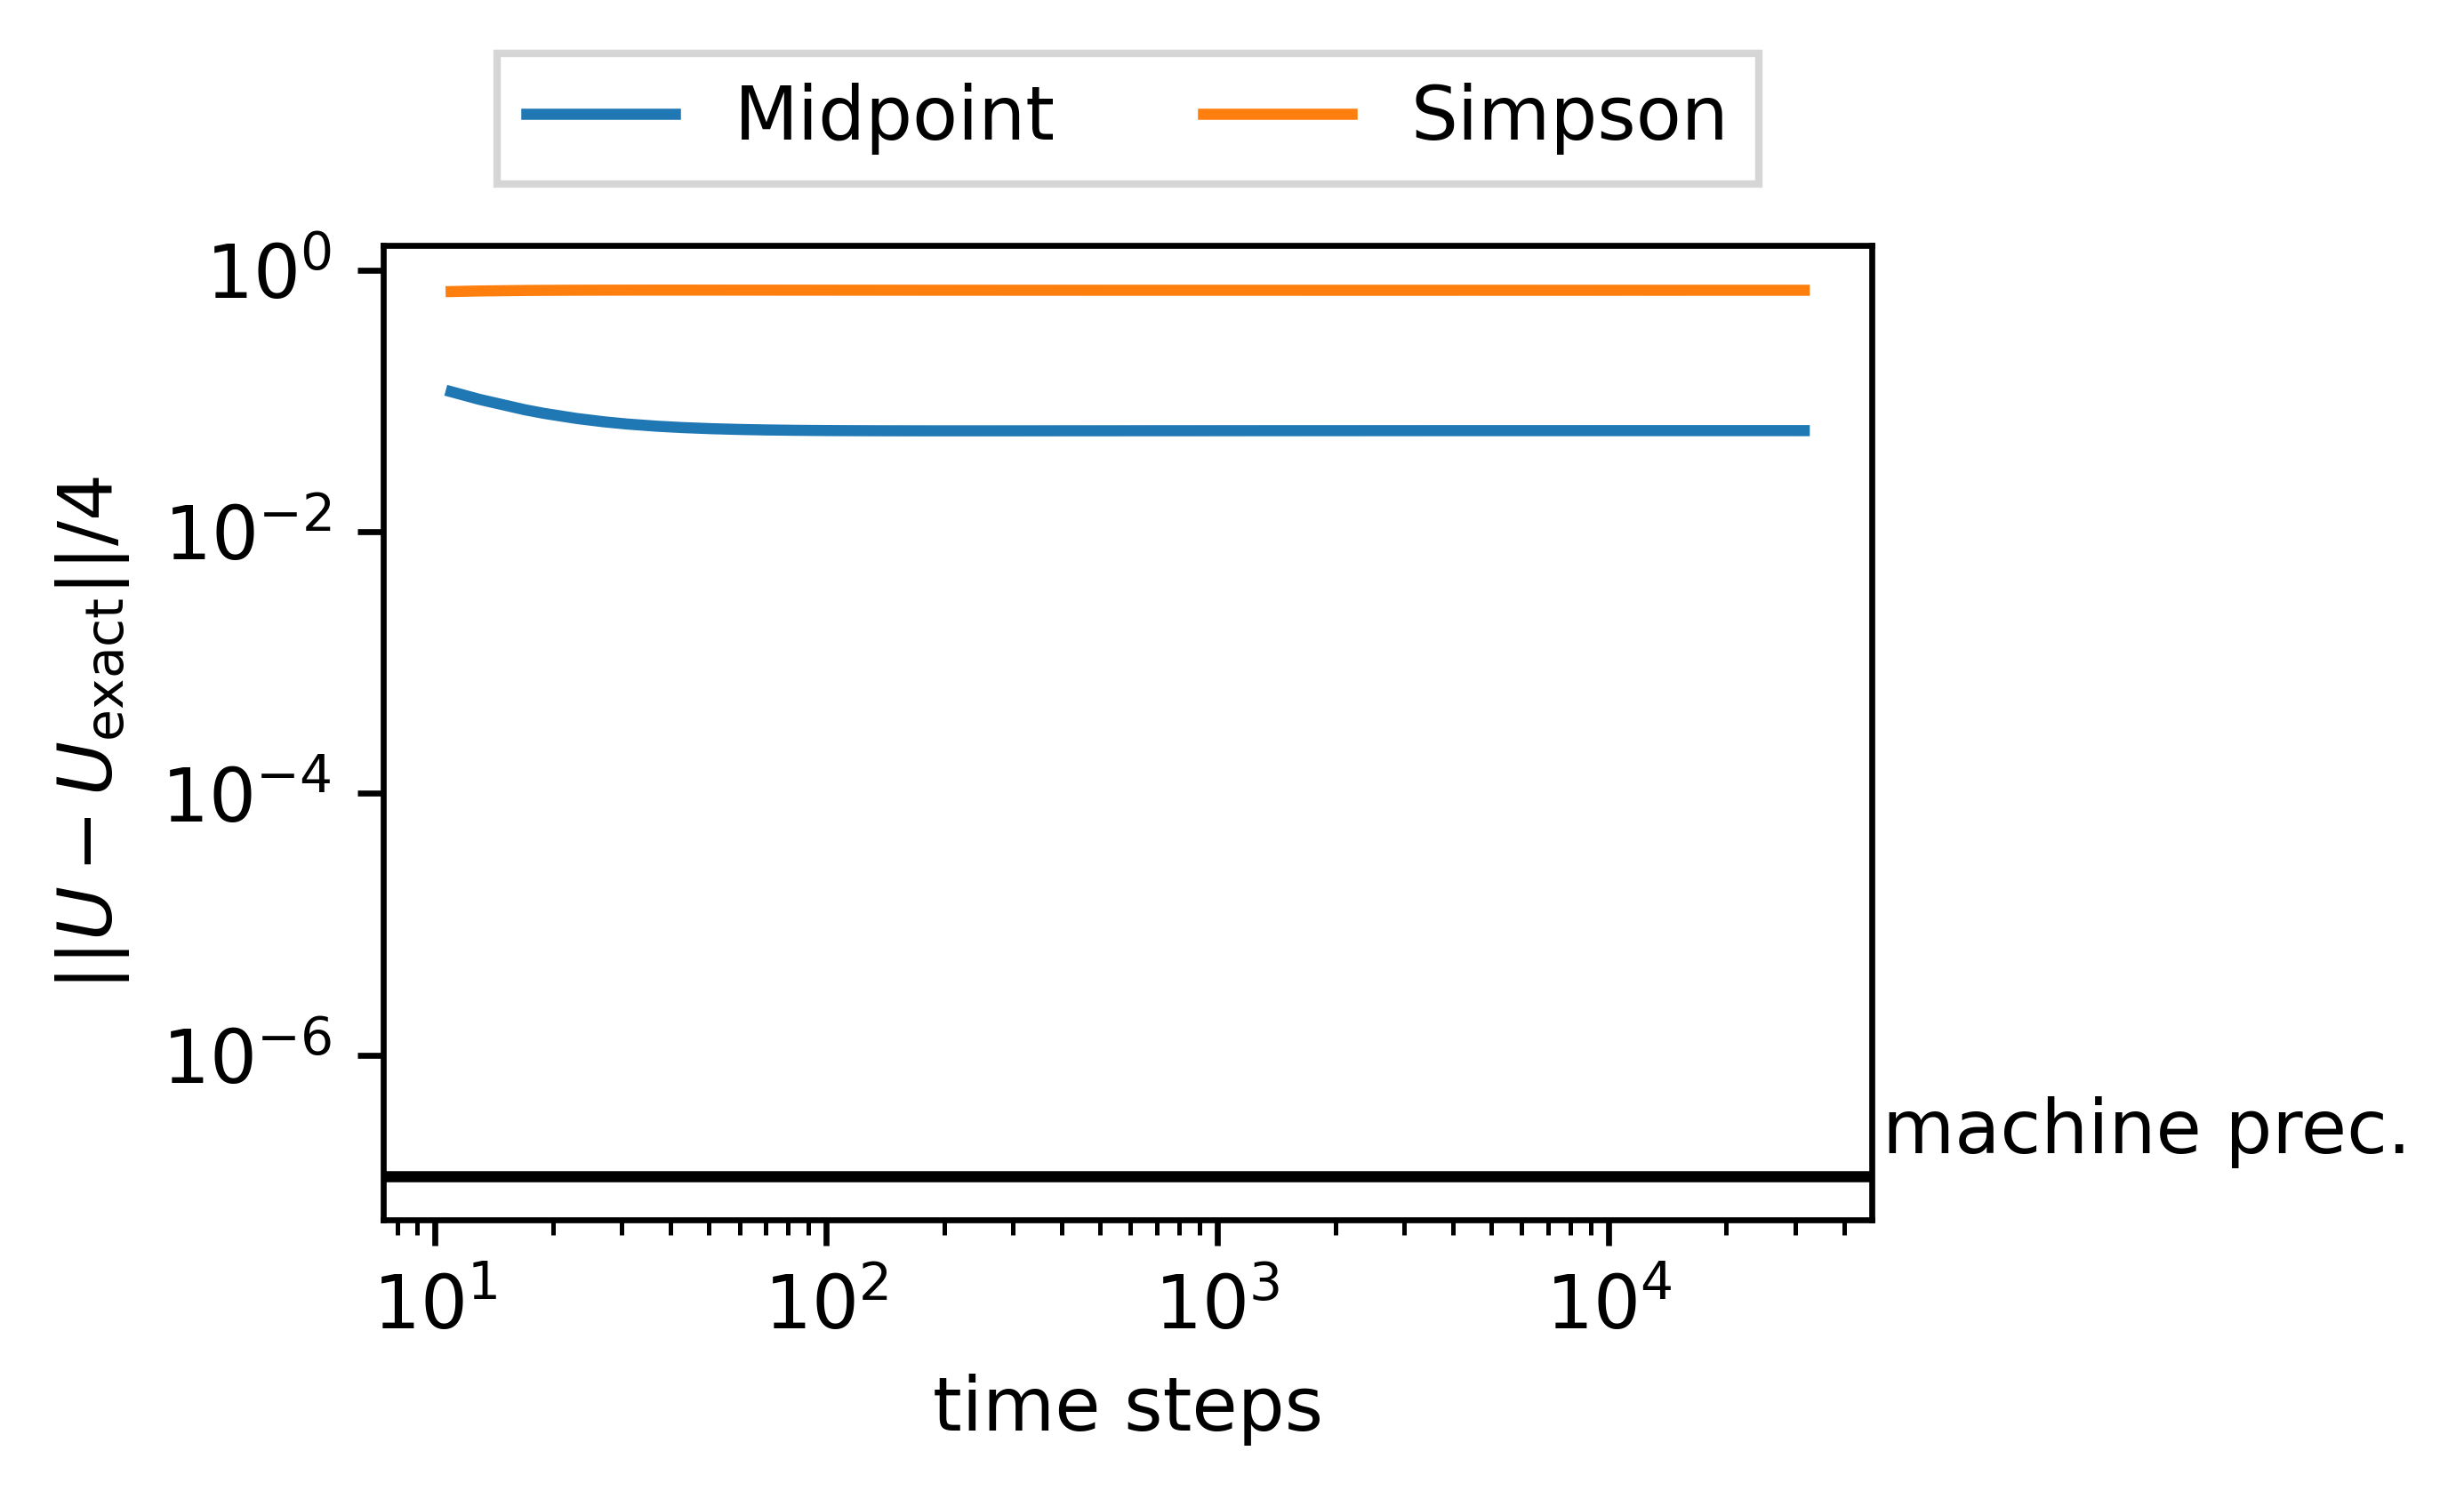

In [27]:
golden_ratio = 1.61803398875
inch = 0.0393701
size = 120
plt.figure(figsize=(size*inch,size*inch/golden_ratio),dpi=600)
plt.loglog(steps,np.array(y2)/4,label='Midpoint')
plt.loglog(steps,np.array(y3)/4,label='Simpson')
#plt.loglog(steps,np.array(y1)/4,label='Magnus')
plt.ylabel('$||U-U_\mathrm{exact}||/4$')
plt.xlabel('time steps')
plt.axhline(2**-23,c='k')
plt.text(5e4,1.5*2**-23,'machine prec.')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.025),
          ncol=3, fancybox=False, shadow=False)
plt.tight_layout()
plt.savefig('fp32_convergence.svg')

In [ ]:
steps = np.logspace(1.1,6.1,dtype=int)
for i in range(len(steps)):
    if steps[i] % 2 == 0:
        steps[i] = steps[i]+1

In [ ]:
steps = np.array([     13,      15,      21,      25,      33,      41,      51,
            65,      83,     105,     131,     167,     211,     267,
           337,     427,     541,     683,     865,    1093,    1383,
          1749,    2217,    2799,    3539,    4477,    5663,    7163,
          9061,   11459,   14495,   18335,   23191,   29333,   37101,
         46927,   59357,   75077,   94963,  120113,  151927,  192165,
        243061,  307437,  388863,  491855,  622125,  786897,  995311,
       1258925])

In [29]:
z1 = qu.serial_map(compare,steps,task_args=('fp64',True,'simpson'))
z2 = qu.serial_map(compare,steps,task_args=('fp64',False,'midpoint'))
z3 = qu.serial_map(compare,steps,task_args=('fp64',False,'simpson'))

11
[[ 0.94499247-0.30866503j  0.03134256-0.10359911j]
 [-0.03134256-0.10359911j  0.94499247+0.30866503j]]
------------
2.7449984957943347
11
[[ 0.94499247-0.30866503j  0.03134256-0.10359911j]
 [-0.03134256-0.10359911j  0.94499247+0.30866503j]]
------------
2.7449984957943347
13
[[ 0.96999213-0.21243903j  0.02317797-0.11596424j]
 [-0.02317797-0.11596424j  0.96999213+0.21243903j]]
------------
2.7739129418825827
17
[[ 0.98763254-0.08957188j  0.00965895-0.12831819j]
 [-0.00965895-0.12831819j  0.98763254+0.08957188j]]
------------
2.7999623043201747
19
[[ 0.99012965-0.04828195j  0.00449241-0.13149884j]
 [-0.00449241-0.13149884j  0.99012965+0.04828195j]]
------------
2.806129437188378
23
[[ 0.99074375+0.01184668j -0.00346816-0.13518303j]
 [ 0.00346816-0.13518303j  0.99074375-0.01184668j]]
------------
2.8128445670317856
27
[[ 0.98908033+0.05342457j -0.00921845-0.13704359j]
 [ 0.00921845-0.13704359j  0.98908033-0.05342457j]]
------------
2.815926380452407
31
[[ 0.98677946+0.08384248j -0.0135

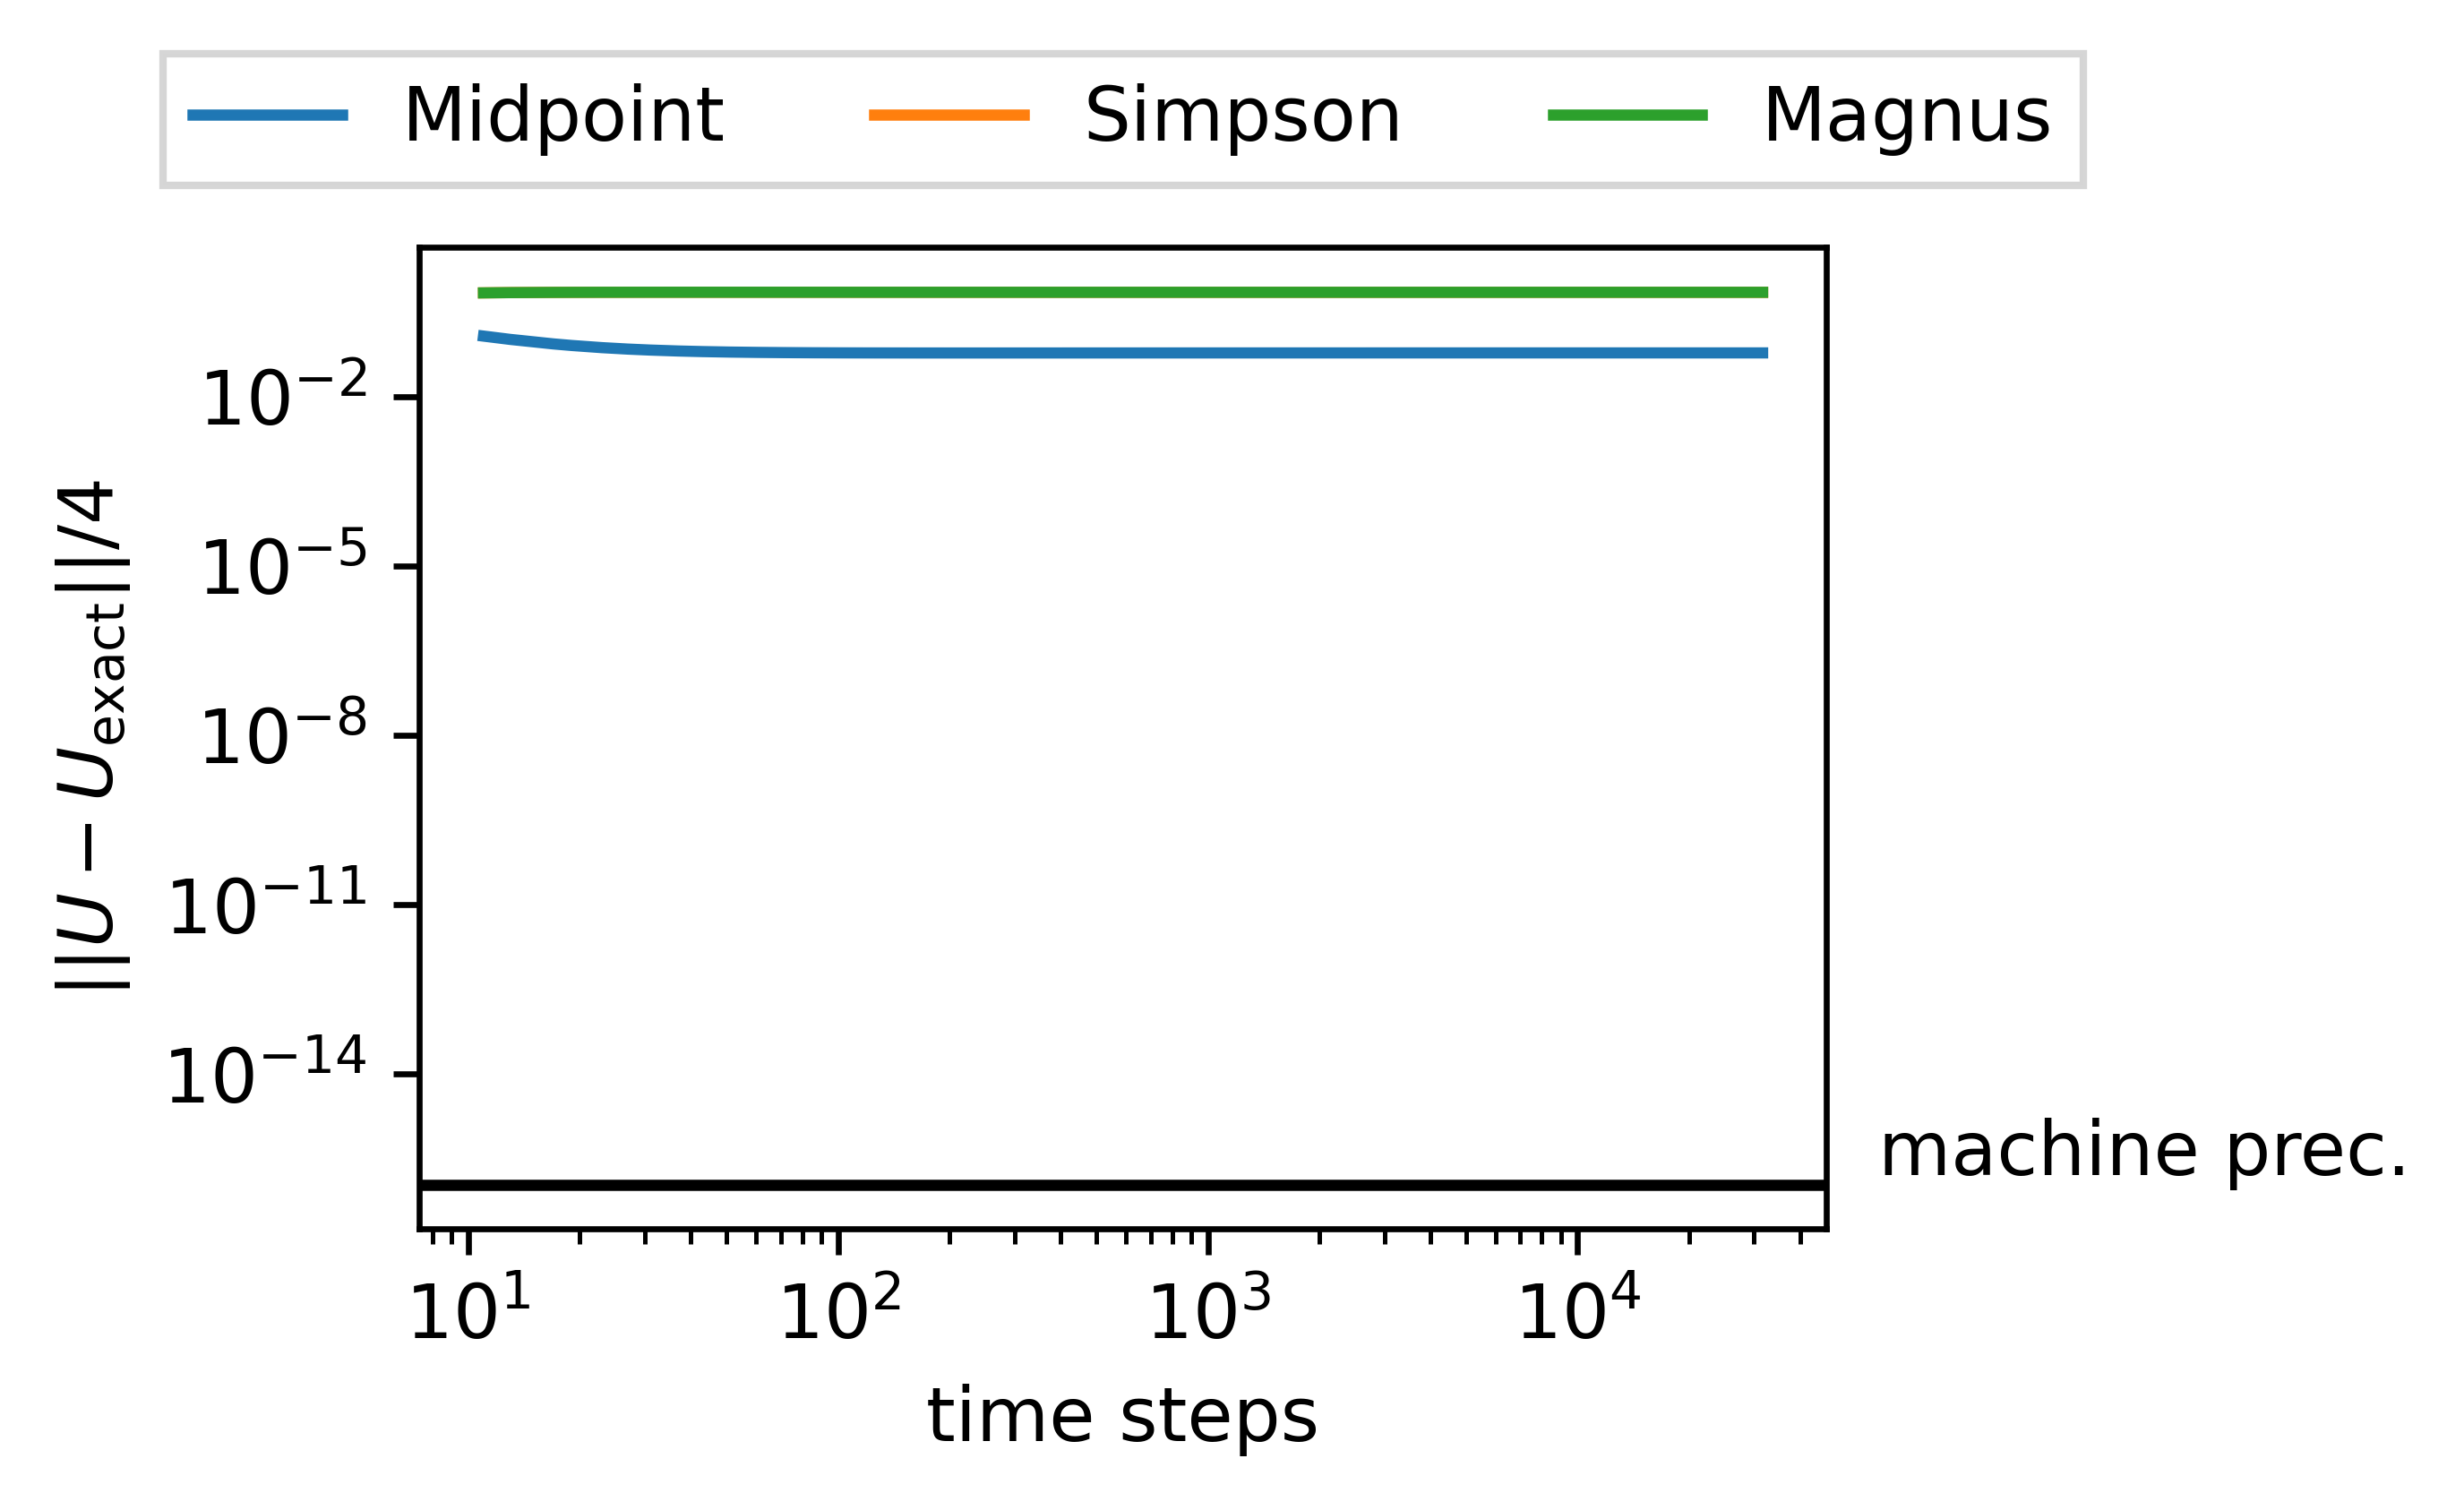

In [30]:
golden_ratio = 1.61803398875
inch = 0.0393701
size = 120
plt.figure(figsize=(size*inch,size*inch/golden_ratio),dpi=600)
plt.loglog(steps,np.clip(np.array(z2)/4,2**-53,100),label='Midpoint')
plt.loglog(steps,np.clip(np.array(z3)/4,2**-53,100),label='Simpson')
plt.loglog(steps,np.clip(np.array(z1)/4,2**-53,100),label='Magnus')
plt.ylabel('$||U-U_\mathrm{exact}||/4$')
plt.xlabel('time steps')
plt.axhline(2**-53,c='k')
plt.text(6.5e4,1.5*2**-53,'machine prec.')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.025),
          ncol=3, fancybox=False, shadow=False)
plt.tight_layout()
plt.savefig('fp64_convergence.svg')

In [ ]:
np.log10(5589165)

6.747346930788167

In [ ]:
for i in range(len(steps)):
    print(steps[i],z1[i])

13 0.001675849848293023
15 0.0009154978726443322
21 0.00022356060309411757
25 0.00010834916344151038
33 3.445178042059811e-05
41 1.4143554768586292e-05
51 5.801754461302332e-06
65 2.1634918883182078e-06
83 8.033468391129024e-07
105 3.1057459819615474e-07
131 1.2723365327891712e-07
167 4.7872704426997236e-08
211 1.868991973477988e-08
267 7.262111256510755e-09
337 2.850276217166983e-09
427 1.1043468615393156e-09
541 4.271369540336611e-10
683 1.6805264263189505e-10
865 6.51898691944489e-11
1093 2.5464155502620447e-11
1383 9.968780130614789e-12
1749 3.3253773237959596e-12
2217 0.0
2799 0.0
3539 0.0
4477 0.0
5663 0.0
7163 0.0
9061 0.0
11459 0.0
14495 1.390221271435621e-12
18335 0.0
23191 0.0
29333 2.8162469897714635e-12
37101 0.0
46927 1.0654810367327627e-12
59357 2.2437341031877854e-12
75077 8.206374653336343e-12
94963 6.03287709711511e-12
120113 9.94428409773428e-12
151927 5.692234373281653e-12
192165 1.0232925617970068e-12
243061 6.393987470034224e-12
307437 3.449168034490689e-11
388863 